In [1]:
from openai import OpenAI
import numpy as np 
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt

In [2]:
client = OpenAI()

# EXPERIMENT 1

In [3]:
# Loading in data:
exp1_stimuli = pd.read_csv('experiment1stimuli.csv')

In [4]:
exp1_stimuli.head()

,intendedword,shownword,poem_number,poem_text,condition
0,rest,others,a,"At speaking my mind,\n I'm one of the best.\n ...",AT
1,rest,rest,a,"At speaking my mind,\n I'm one of the best.\n ...",IT
2,rest,stressed,a,"At speaking my mind,\n I'm one of the best.\n ...",RHYME
3,rest,cashier,a,"At speaking my mind,\n I'm one of the best.\n ...",FILLER
4,hello,howdy,b,Just a brown fellow\n who's not afraid of Jell...,AT


To make comparisons fair, we provide the model with instructions and practice trials.

In [5]:
instructions = """INSTRUCTIONS: In this experiment, you will read a lyric with the final word left blank, as indicated by the sequence '______.' You will then be presented a word and the token [BLACK BOX]

If the word serves as a proper continuation of the lyric, please choose the word. If the word does not serve as a proper continuation of the lyric, please choose the [BLACK BOX] token."""

In [6]:
practice_trial_1 = """
Twinkle twinkle
little star.
How I wonder
what you ______.

Can the following word fill in the blank?: are

are         [BLACK BOX]

Above, you should choose the word 'are'. """

In [7]:
practice_trial_2 = """
Humpty dumpty
sat on a wall.
Humpty dumpty
had a great ______.

Can the following word fill in the blank?: running

Please select one of the following, given the instructions:
running         [BLACK BOX]

Above, you should choose the [BLACK BOX] token. """

Now, to run our rhyme-completion task:

In [8]:
def exp1_generations(input_row, instructions=instructions, pt1 = practice_trial_1, pt2=practice_trial_2):
    word = input_row[1]
    targets = [word, '[BLACK BOX]']

    # Randomizing position of word and [BLACK BOX]
    random.shuffle(targets)

    # Joining the targets into a string:
    target_string = '\t\t'.join(targets)

    # Rhyme text
    rhyme = input_row[-2]

    completion = client.chat.completions.create(
        model="gpt-4",
        messages=[
        {"role": "system", "content": instructions},
        {"role": "system", "content": pt1},
        {"role": "system", "content": pt2},
        {"role": "user", "content": f"""{rhyme}
        Can the following word fill in the blank?: {word}
     
        Please select one of the following, given the instructions:
        {target_string}
        
        Respond with your choice only. Do not add any additional text or structure besides the token you select."""}
        ]
    )
    return completion.choices[0].message.content

In [9]:
# Demo
exp1_generations(exp1_stimuli.iloc[0])

'[BLACK BOX]'

### Generating GPT4 Responses

In [10]:
# Iterating over rows three times:
exp1_gpt4_1 = []
for i in range(len(exp1_stimuli)):
    exp1_gpt4_1.append(exp1_generations(exp1_stimuli.iloc[i]))


exp1_gpt4_2 = []
for i in range(len(exp1_stimuli)):
    exp1_gpt4_2.append(exp1_generations(exp1_stimuli.iloc[i]))


exp1_gpt4_3 = []
for i in range(len(exp1_stimuli)):
    exp1_gpt4_3.append(exp1_generations(exp1_stimuli.iloc[i]))

In [11]:
# Adding to our dataframe:
exp1_stimuli['gpt4_selections_1'] = exp1_gpt4_1
exp1_stimuli['gpt4_selections_2'] = exp1_gpt4_2
exp1_stimuli['gpt4_selections_3'] = exp1_gpt4_3

In [12]:
def code_accept_reject(string):
    if string == '[BLACK BOX]':
        return 'Reject'
    else:
        return 'Accept'

In [13]:
exp1_stimuli['decision_1'] = exp1_stimuli['gpt4_selections_1'].apply(code_accept_reject)
exp1_stimuli['decision_2'] = exp1_stimuli['gpt4_selections_2'].apply(code_accept_reject)
exp1_stimuli['decision_3'] = exp1_stimuli['gpt4_selections_3'].apply(code_accept_reject)

In [14]:
exp1_stimuli.head()

,intendedword,shownword,poem_number,poem_text,condition,gpt4_selections_1,gpt4_selections_2,gpt4_selections_3,decision_1,decision_2,decision_3
0,rest,others,a,"At speaking my mind,\n I'm one of the best.\n ...",AT,[BLACK BOX],[BLACK BOX],[BLACK BOX],Reject,Reject,Reject
1,rest,rest,a,"At speaking my mind,\n I'm one of the best.\n ...",IT,rest,rest,rest,Accept,Accept,Accept
2,rest,stressed,a,"At speaking my mind,\n I'm one of the best.\n ...",RHYME,[BLACK BOX],[BLACK BOX],[BLACK BOX],Reject,Reject,Reject
3,rest,cashier,a,"At speaking my mind,\n I'm one of the best.\n ...",FILLER,[BLACK BOX],[BLACK BOX],[BLACK BOX],Reject,Reject,Reject
4,hello,howdy,b,Just a brown fellow\n who's not afraid of Jell...,AT,howdy,howdy,howdy,Accept,Accept,Accept


Let's make our DataFrame a bit more interpretable:

In [15]:
def exp1_cleaning(dataframe, iteration='1'):
    decision = f'decision_{iteration}'

    mini_df = dataframe[['condition', decision]].copy()
    mini_df = mini_df.rename(columns={decision:'decision'})
    return mini_df

In [16]:
run_1 = exp1_cleaning(exp1_stimuli)
run_2 = exp1_cleaning(exp1_stimuli, iteration='2')
run_3 = exp1_cleaning(exp1_stimuli, iteration='3')

In [17]:
exp1_output = pd.concat([run_1, run_2, run_3])

Now, calculating the acceptance rates per condition:

In [18]:
exp1_output = exp1_output[['condition', 'decision']].copy()

In [19]:
exp1_plot = exp1_output.groupby('condition').value_counts().reset_index().rename(columns={0:'Selection Rate', 'condition':'Condition'})
exp1_plot = exp1_plot[exp1_plot['decision'] == 'Accept']
exp1_plot['Selection Rate'] = exp1_plot['Selection Rate'].apply(lambda x: x/48)

In [20]:
exp1_plot

,Condition,decision,Selection Rate
0,AT,Accept,0.937500
3,FILLER,Accept,0.062500
4,IT,Accept,1.000000
6,RHYME,Accept,0.416667


In [21]:
# Saving relevant CSV file for easy access
exp1_plot.to_csv('exp1_plot.csv', index=False)

Plotting:

In [22]:
exp1_plot = pd.read_csv('exp1_plot.csv')

In [23]:
exp1_plot

,Condition,decision,Selection Rate
0,AT,Accept,0.937500
1,FILLER,Accept,0.062500
2,IT,Accept,1.000000
3,RHYME,Accept,0.416667


In [24]:
# Reconfiguring column names
exp1_plot = exp1_plot.rename(columns={'Selection Rate': 'Target Acceptance Rate'})

In [25]:
sns.set(rc = {'figure.figsize':(14,4)})
sns.set(font_scale = 2)

In [26]:
custom_palette = ["skyblue", "orange", "purple", "green"]
sns.set_palette(custom_palette)

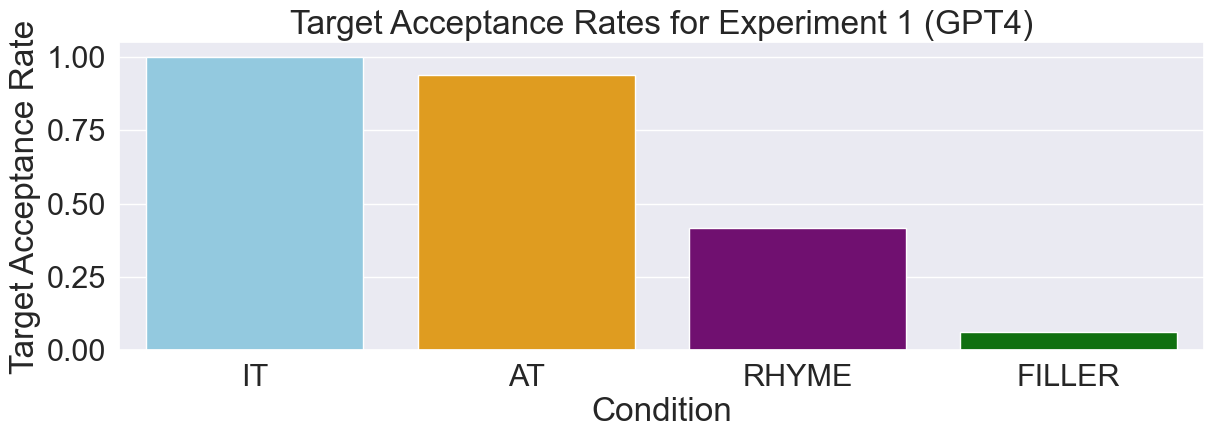

In [27]:
sns.barplot(x="Condition", y="Target Acceptance Rate", data=exp1_plot, order=['IT', 'AT', 'RHYME', 'FILLER'])
plt.title("Target Acceptance Rates for Experiment 1 (GPT4)")
plt.savefig('exp1ratesgpt4.png', dpi=300, bbox_inches='tight')